# **Task1**

### **Stage -1:** _Importing libs_

In [1]:
from typing import Optional, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as mpl_axes
import sklearn as sl
import scipy
import seaborn as sns
import statsmodels.api as sm

### **Stage 0:** _Master-classes for data and graph processing_

##### **_Plotter_**

In [2]:
class Plotter:
    def __init__(self, nrows: int = 1, ncols: int = 1, figsize: Tuple[int, int] = (6, 6)) -> None:
        self.fig, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        self.nrows = 0
        self.ncols = 0
        
        if nrows == 1 and ncols == 1:
            self.axes = np.array([self.axes])
        elif nrows == 1 or ncols == 1:
            self.axes = self.axes.reshape(-1)
        else:
            self.axes = self.axes.flatten()

        self.position = None
    
    def __getitem__(self, index: int):
        return self._get_axes_by_index(index)
    
    def __getattr__(self, name: str):
        if hasattr(mpl_axes.Axes, name):
            def dynamic_method(*args, 
                             idx: Optional[int] = None,
                             irow: Optional[int] = None,
                             icol: Optional[int] = None,
                             **kwargs):
                ax = self._get_axis(idx, irow, icol) if self.position is None else self.position
                method = getattr(ax, name)
                return method(*args, **kwargs)
            
            return dynamic_method
        
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")
    
    def _get_axes_by_index(self, idx: int = 0) -> Any:
        return self.axes[idx]
    
    def _get_axes_by_coords(self, irow: int = 0, icol: int = 0) -> Any:
        idx = irow * self.ncols + icol
        return self.axes[idx]

    def _get_axis(self,
                  idx: Optional[int] = None,
                  irow: Optional[int] = None,
                  icol: Optional[int] = None) -> Any:
        if idx is not None:
            return self._get_axes_by_index(idx)
        elif irow is not None and icol is not None:
            return self._get_axes_by_coords(irow, icol)
        else:
            raise ValueError("ERROR: Wrong indexation!")
    
    def set_position(self,
                     idx: Optional[int] = None,
                     irow: Optional[int] = None,
                     icol: Optional[int] = None) -> None:
        
        self.position = self._get_axis(idx, irow, icol)
    
    def del_position(self) -> None:
        self.position = None
        
    def labels(self,
               xlabel: str,
               ylabel: str,
               title: str,
               idx: Optional[int] = None,
               irow: Optional[int] = None,
               icol: Optional[int] = None) -> None:

        ax = self._get_axis(idx, irow, icol) if self.position is None else self.position
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        return ax

    def tight_layout(self) -> None:
        self.fig.tight_layout()
    
    def save(self, path: str, dpi: int = 300, **kwargs) -> None:
        self.fig.savefig(path, dpi=dpi, **kwargs)
    
    def show(self) -> None:
        self.fig.show()


##### **_Data processor_**

In [3]:
class MainFrame:
    def __init__(self) -> None:
        self.iris = sns.load_dataset("iris")

        self.shape = self.iris.shape

        self.params_count = len(self.iris.columns) - 1
        self.params = self.iris.columns[:self.params_count]
        
        self.iris["target"], self.classes = pd.factorize(self.iris["species"])
        _, self.classes_counts = np.unique(self.iris["species"], return_counts=True)
        self.classes_count = len(self.classes)
        
        self.styles = ["o", "s", "^"]
        self.colors = ["red", "green", "blue"]
        
        self.stats = np.zeros((self.params_count, self.params_count, 16))
        
        self.data = []
        self.data_by_class = [[] for _ in range(self.classes_count)]
    
    def clear_null(self) -> None:
        self.iris = self.iris.dropna().reset_index(drop=True)
    
    def data_stats(self, data1, data2) -> Any:
        pirson_v, pirson_pv = scipy.stats.pearsonr(data1, data2)
        spearman_v, spearman_pv = scipy.stats.spearmanr(data1, data2)

        return np.array([pirson_v, pirson_pv, spearman_v, spearman_pv])
    
    def main_loop(self) -> Any:
        for i, iparam in enumerate(self.params):
            for j, jparam in enumerate(self.params):
                data = np.array(self.iris[[iparam, jparam, "target"]])
                self.data.append(data)
                
                self.stats[i, j, 0:4] = self.data_stats(data[..., 0], data[..., 1])

                for k, group in enumerate(self.classes):
                    data_by_class = data[data[..., -1] == k]
                    self.data_by_class[k].append(data_by_class)
                    
                    self.stats[i, j, (k + 1) * 4:(k + 2) * 4] = self.data_stats(data_by_class[..., 0], data_by_class[..., 1])
                    ...
                ...
            ...
        ...


### **Stage1** (tasks [1] [2]): _Loading data_

In [4]:
# step1
main = MainFrame()

# 2 step
print(f"Dataframe size: {main.shape[0]}x{main.shape[1]}")
print(f"Count of features: {main.params_count}")
print(f"Num classes: {main.classes_count}")
print("Class counts:")
for name, count in zip(main.classes, main.classes_counts):
    print(f" - {name}: {count}")

null_values_count = main.iris.isnull().sum().sum()
print(f"Null values: {null_values_count} ({(main.iris.isnull().sum().sum() / main.iris.size * 100):.2f}%)")

if null_values_count > 0:
    main.clear_null()
    
# step3
main.main_loop()

Dataframe size: 150x5
Count of features: 4
Num classes: 3
Class counts:
 - setosa: 50
 - versicolor: 50
 - virginica: 50
Null values: 0 (0.00%)


### **Stage 2** (task [3]): _Simple params visualization_

##### **_Data scatters_**

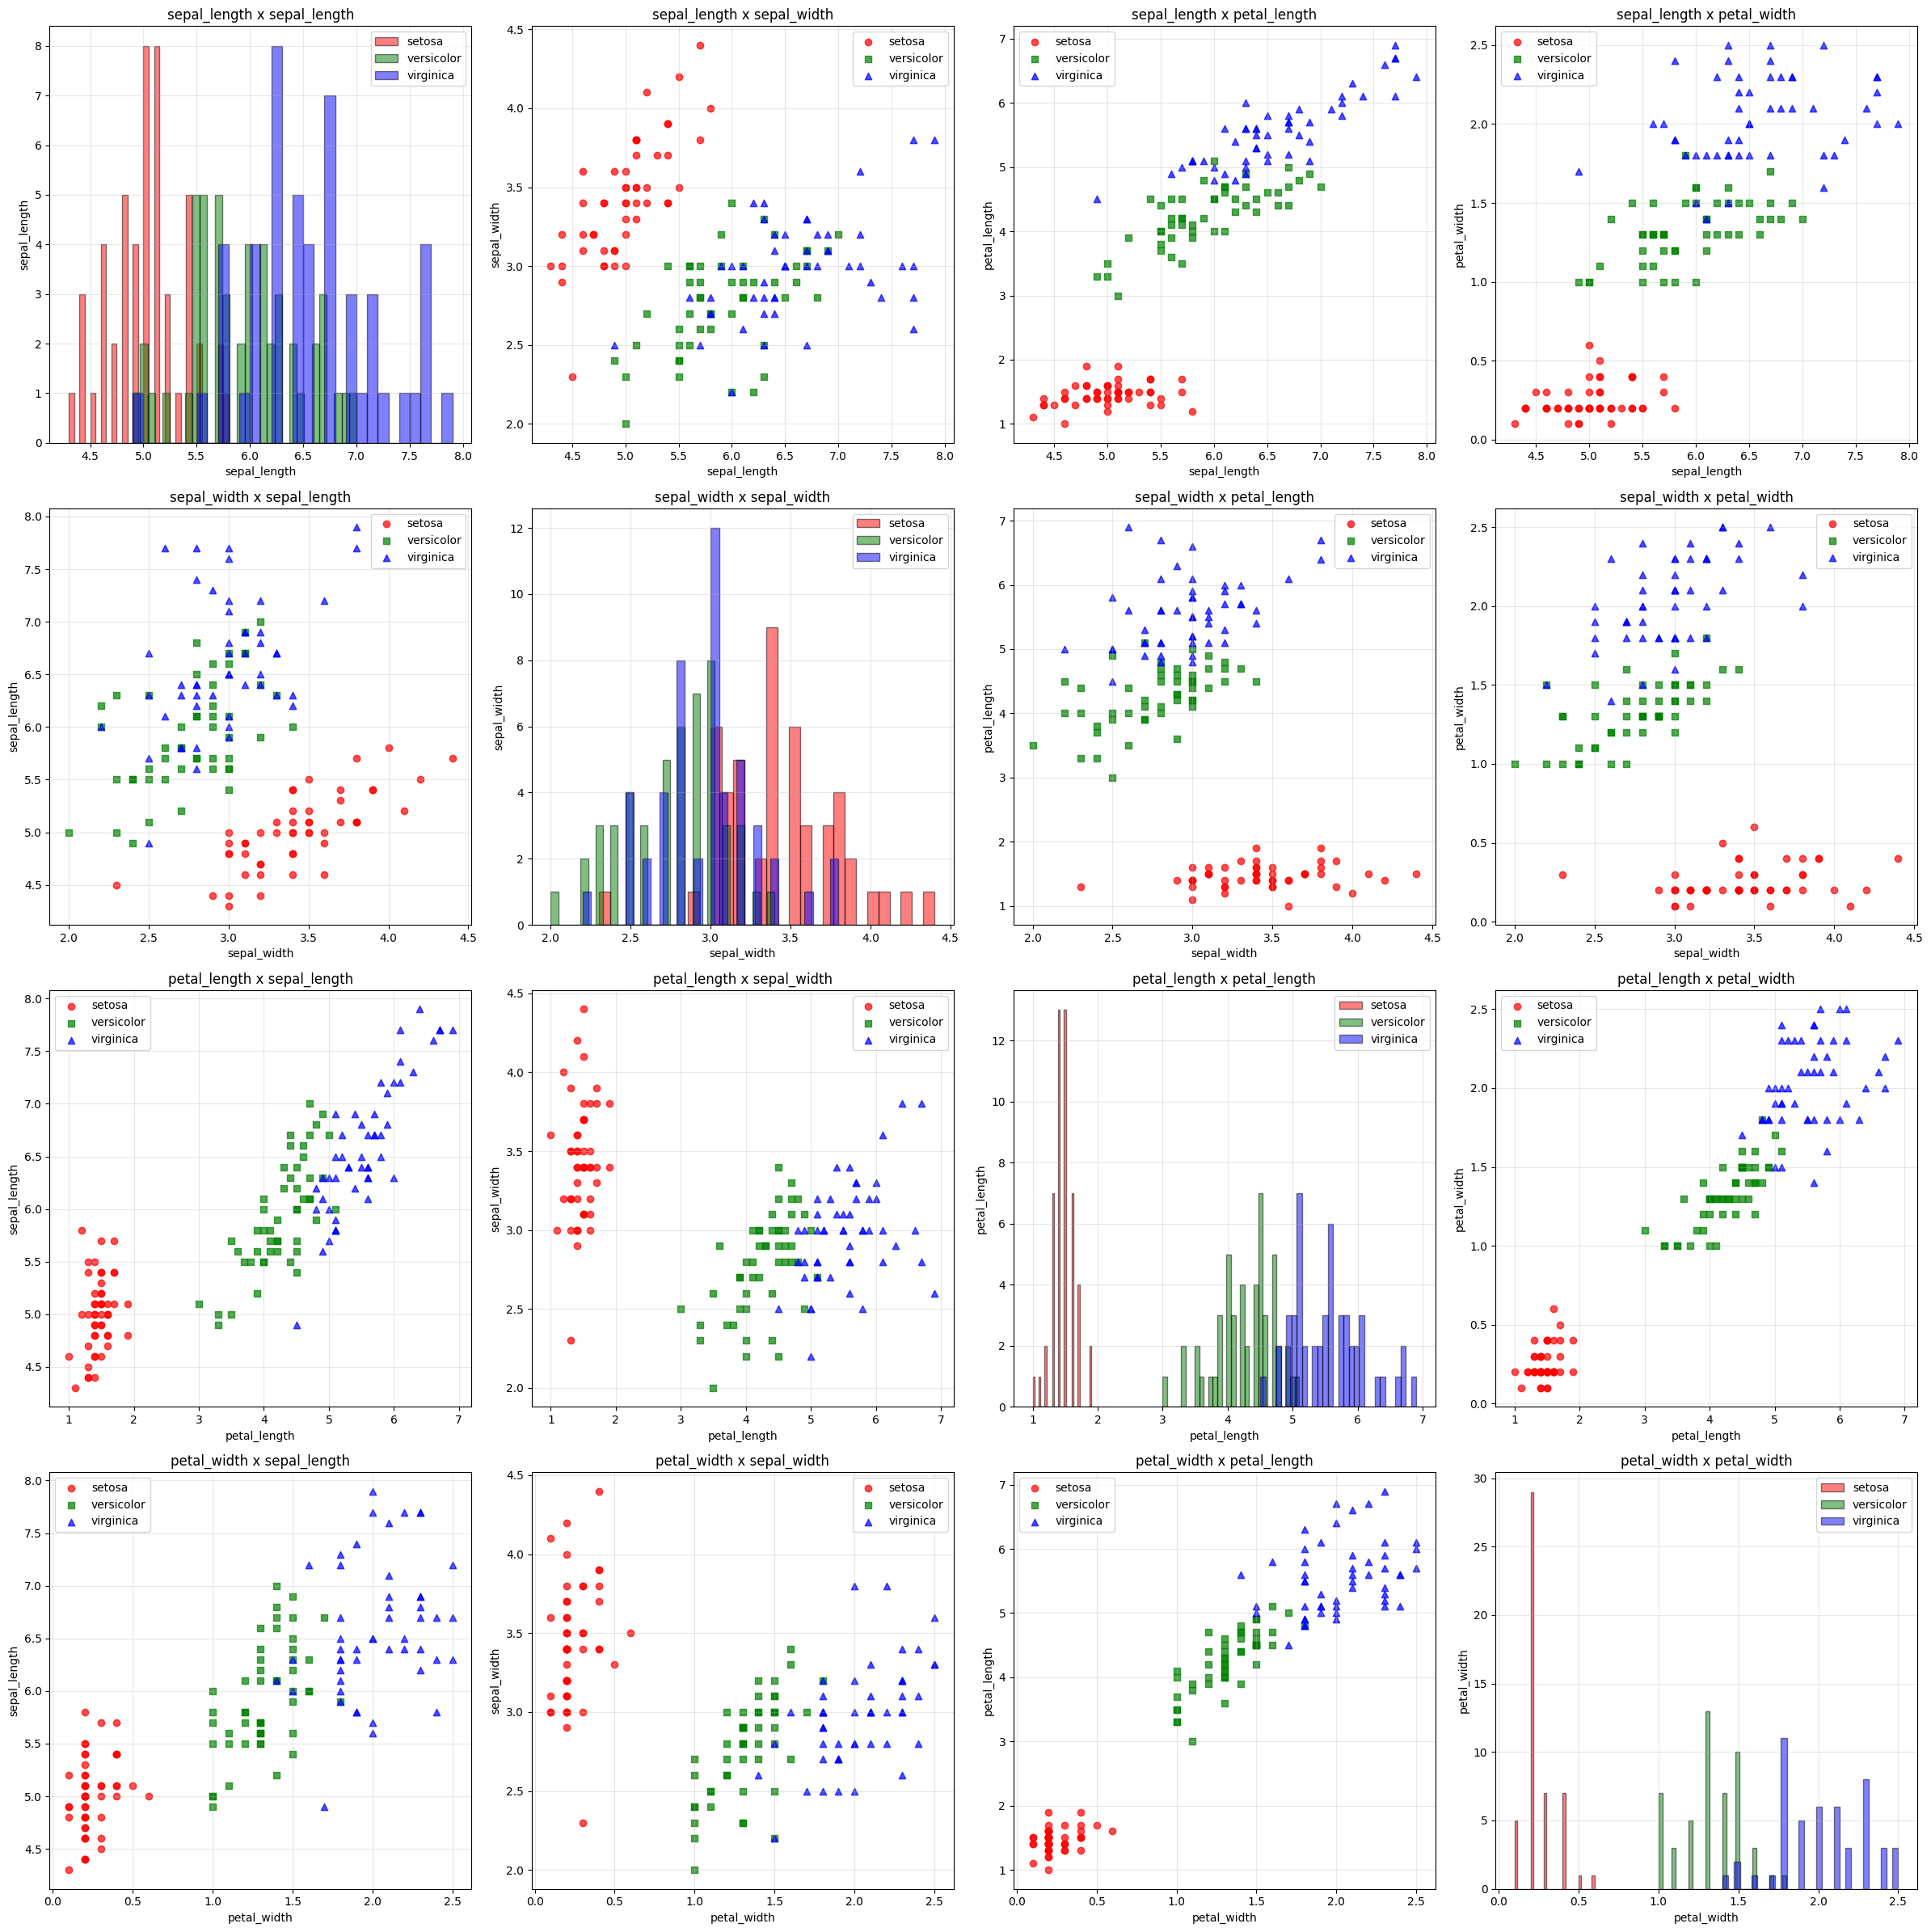

In [ ]:
# step4
plotter = Plotter(4, 4, (24, 24))

for i in range(len(main.data)):
    plotter.set_position(idx=i)
    for j, group in enumerate(main.classes):
        if (i // main.params_count) != (i % main.params_count):
            plotter.scatter(main.data_by_class[j][i][..., 0],
                            main.data_by_class[j][i][..., 1],
                            marker=main.styles[j], color=main.colors[j], alpha=0.7, label=group)
        else:
            plotter.hist(main.data_by_class[j][i][..., 0],
                         bins=30, color=main.colors[j], alpha=0.5, edgecolor="black", label=group)
    iparam, jparam = main.params[i // main.params_count], main.params[i % main.params_count]
    plotter.labels(iparam, jparam, f"{iparam} x {jparam}")
    plotter.grid(True, alpha=0.3)
    plotter.legend()
    plotter.del_position()

plotter.tight_layout()
plotter.save("res/scatters1.png", dpi=200)

##### **_Param hists_**

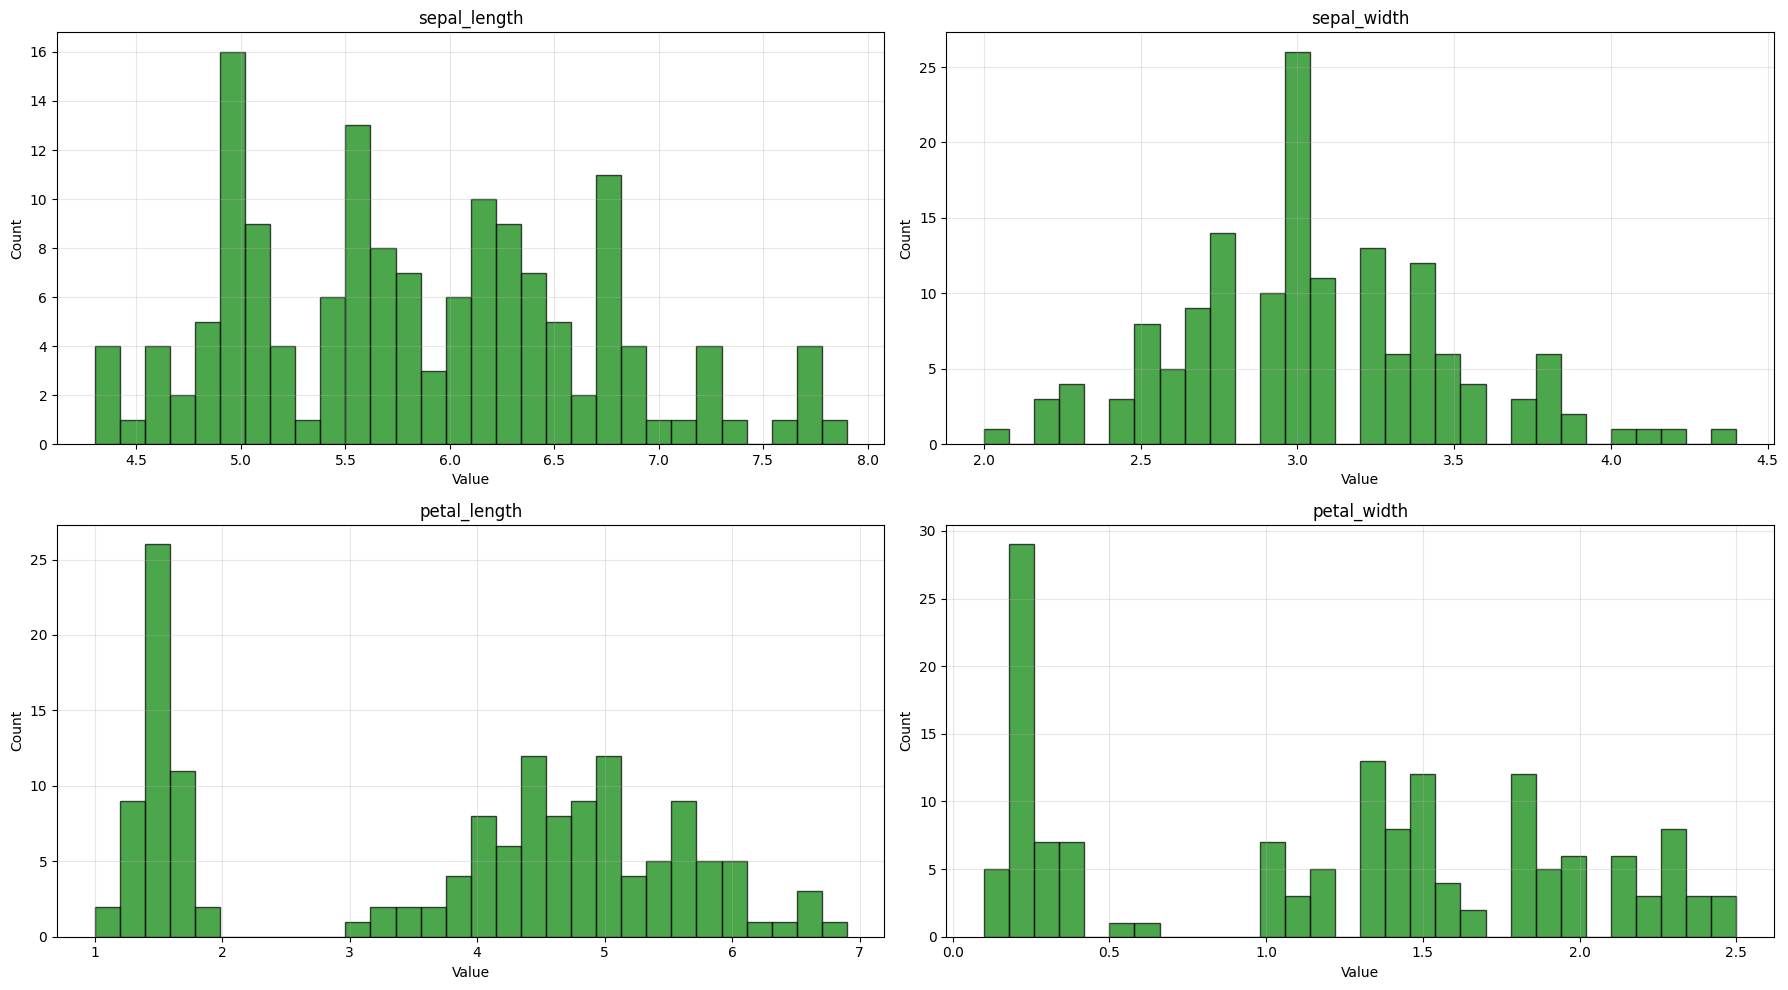

In [8]:
# step5
plotter = Plotter(2, 2, (18, 10))

for j, param in enumerate(main.params):
    plotter.set_position(idx=j)
    plotter.hist(main.iris[param], bins=30, color="green", edgecolor="black", alpha=0.7)
    plotter.labels("Value", "Count", param)
    plotter.grid(True, alpha=0.3)
    plotter.del_position()

plotter.save("res/hists.png", dpi=200)
plotter.tight_layout()

### **Stage 3** (task [4]): _Correlation matrixes_

##### **__**